In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub

import os
import numpy as np

import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

In [2]:
datasets, info = tfds.load(name='beans', with_info=True, as_supervised=True, split=['train','test','validation'])

Dataset beans downloaded and prepared to /home/aditya/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
    by experts from the National Crops Resources Research Institute (NaCRRI) in
    Uganda and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path='/home/aditya/tensorflow_datasets/beans/0.1.0',
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo num_examples=1034, num_shards=2>,
  

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


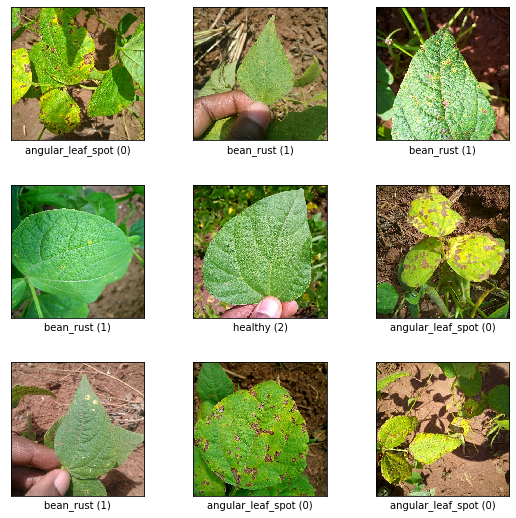

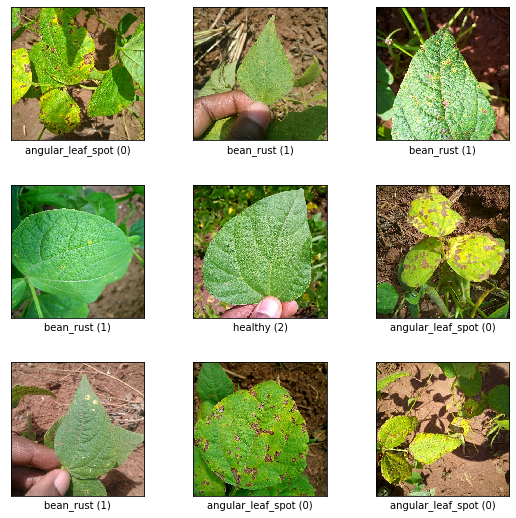

In [4]:
train, info_train = tfds.load(name='beans', with_info=True, split='test')
tfds.show_examples(info_train,train)

In [5]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0

  return tf.image.resize(image,[224,224]), tf.one_hot(label, 3)

In [6]:
def get_dataset(batch_size=32):
  train_dataset_scaled = datasets[0].map(scale).shuffle(1000).batch(batch_size)
  test_dataset_scaled =  datasets[1].map(scale).batch(batch_size)
  val_dataset_scaled =  datasets[2].map(scale).batch(batch_size)
  return train_dataset_scaled, test_dataset_scaled, val_dataset_scaled

In [7]:
train_dataset, test_dataset, val_dataset = get_dataset()
train_dataset.cache()
val_dataset.cache()

<CacheDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>

In [8]:
len(list(datasets[0]))

1034

In [9]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [10]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [11]:
feature_extractor_layer.trainable = False

In [12]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [14]:
history = model.fit(train_dataset, epochs=6, validation_data=val_dataset)                             

Epoch 1/6
33/33 [==============================] - 74s 2s/step - loss: 0.9760 - acc: 0.5561 - val_loss: 0.8179 - val_acc: 0.7744
Epoch 2/6
33/33 [==============================] - 84s 3s/step - loss: 0.7947 - acc: 0.7718 - val_loss: 0.7584 - val_acc: 0.8346
Epoch 3/6
33/33 [==============================] - 93s 3s/step - loss: 0.7552 - acc: 0.8046 - val_loss: 0.7345 - val_acc: 0.8571
Epoch 4/6
33/33 [==============================] - 102s 3s/step - loss: 0.7275 - acc: 0.8443 - val_loss: 0.7161 - val_acc: 0.8647
Epoch 5/6
33/33 [==============================] - 108s 3s/step - loss: 0.7102 - acc: 0.8569 - val_loss: 0.7137 - val_acc: 0.8647
Epoch 6/6
33/33 [==============================] - 110s 3s/step - loss: 0.6951 - acc: 0.8714 - val_loss: 0.6922 - val_acc: 0.8797


[[9.3612117e-01 6.3710138e-02 1.6876619e-04]]


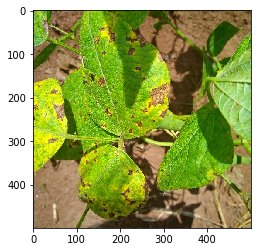

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
[[5.7867920e-04 9.9780530e-01 1.6160236e-03]]


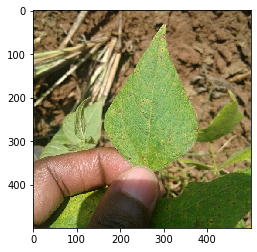

Actual Label: bean_rust
Predicted Label: bean_rust
[[0.73177946 0.18294981 0.0852707 ]]


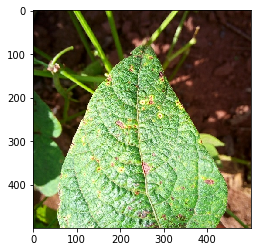

Actual Label: bean_rust
Predicted Label: angular_leaf_spot
[[0.00443083 0.04700573 0.9485634 ]]


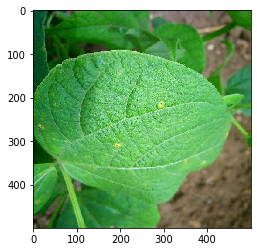

Actual Label: bean_rust
Predicted Label: healthy
[[3.1300829e-04 2.6924512e-03 9.9699450e-01]]


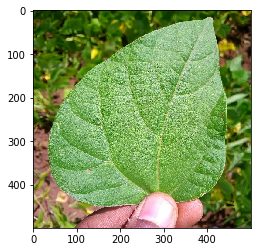

Actual Label: healthy
Predicted Label: healthy
[[0.63119316 0.36480442 0.00400245]]


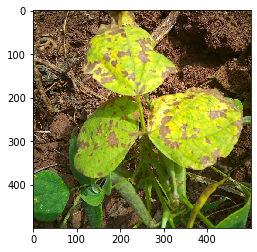

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
[[0.00107979 0.9954786  0.0034417 ]]


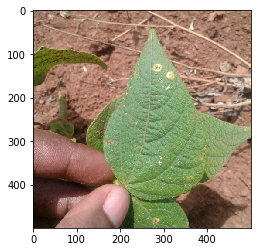

Actual Label: bean_rust
Predicted Label: bean_rust
[[9.9653876e-01 2.5677588e-03 8.9348020e-04]]


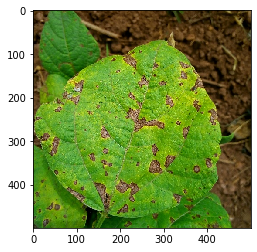

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
[[9.1696978e-01 8.2562581e-02 4.6765563e-04]]


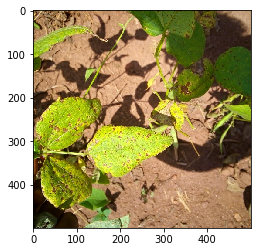

Actual Label: angular_leaf_spot
Predicted Label: angular_leaf_spot
[[0.02978114 0.71236813 0.25785065]]


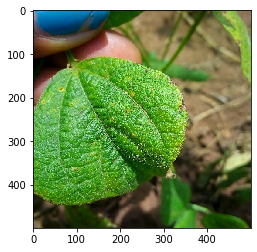

Actual Label: bean_rust
Predicted Label: bean_rust


In [15]:
for test_sample in datasets[1].take(10):  
  image, label = test_sample[0], test_sample[1]
  image_scaled, label_arr= scale(test_sample[0], test_sample[1])
  image_scaled = np.expand_dims(image_scaled, axis=0)   

  img = tf.keras.preprocessing.image.img_to_array(image)                    
  pred=model.predict(image_scaled)
  print(pred)
  plt.figure()
  plt.imshow(image)
  plt.show()
  print("Actual Label: %s" % info.features["label"].names[label.numpy()])
  print("Predicted Label: %s" % info.features["label"].names[np.argmax(pred)])

In [16]:
for f0,f1 in datasets[1].map(scale).batch(200):
  y=np.argmax(f1, axis=1)
  y_pred=np.argmax(model.predict(f0),axis=1)
  print(tf.math.confusion_matrix(labels=y, predictions=y_pred, num_classes=3))

tf.Tensor(
[[39  4  0]
 [ 9 31  3]
 [ 0  1 41]], shape=(3, 3), dtype=int32)
